In [1]:
from numpy.fft import fftn, fftfreq
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import sys

from astropy.cosmology import Planck15 as cosmo
from astropy import units as u

arcmin = 2.908882086656e-4 # [rad] ... PI / 180 / 60 //
arcsec = 4.848136811094e-6 # [rad] ... arcmin / 60 //

In [2]:
data = np.loadtxt("../subgroup_data_TNG300-1_ascii/subgroup.13.txt")
print(data.shape)

(1333857, 11)


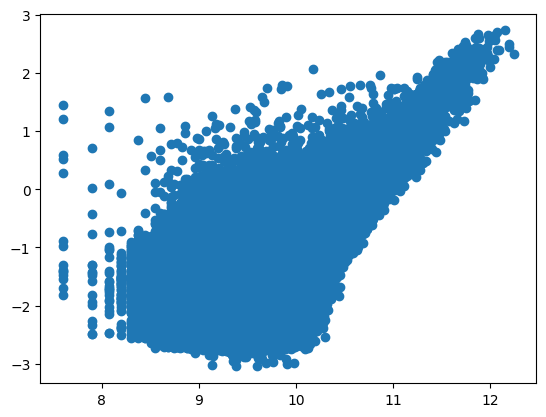

In [3]:
sfr = data[:,3]
mhalo = data[:,5]
plt.scatter(mhalo+10, sfr)


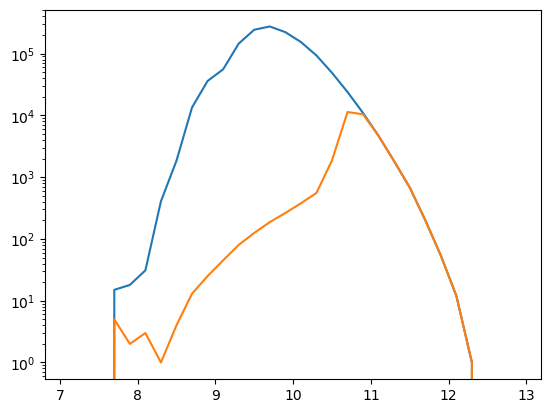

In [5]:
counts, bin_edges = np.histogram(mhalo+10, bins=30, range=(7,13))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

bin_indices = np.digitize(mhalo+10, bin_edges) 
bin_counts = []
non_zero_sfr_counts = []
for i in range(1, len(bin_edges)):
    bin_mask = (bin_indices == i)  
    sfr_bin = sfr[bin_mask] 
    bin_counts.append(len(sfr_bin))   
    non_zero_sfr_counts.append(np.sum(sfr_bin > 0))  

#plt.plot(bin_centers, non_zero_w_ratios, marker='o', linestyle='-')

plt.plot(bin_centers, bin_counts)
plt.plot(bin_centers, non_zero_sfr_counts)
plt.yscale("log")

(0.0, 0.1273488623986236)

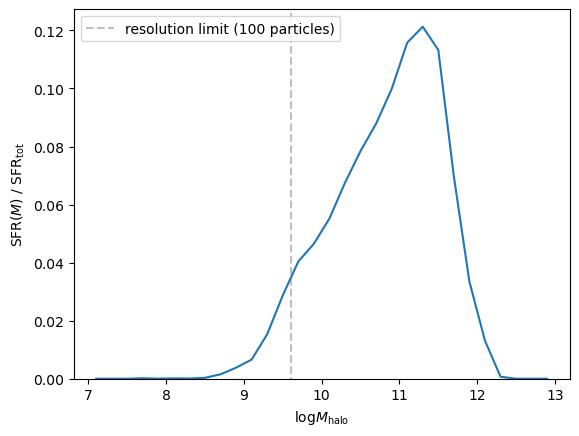

In [17]:
counts, bin_edges = np.histogram(mhalo+10, bins=30, range=(7,13))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

bin_indices = np.digitize(mhalo+10, bin_edges) 
bin_counts = []
non_zero_sfr_counts = []
sfr_tot_bin = []
for i in range(1, len(bin_edges)):
    bin_mask = (bin_indices == i)  
    sfr_bin = sfr[bin_mask] 
    bin_counts.append(len(sfr_bin))   
    sfr_tot_bin.append(np.sum(10**sfr_bin))
    non_zero_sfr_counts.append(np.sum(sfr_bin > 0))  

#plt.plot(bin_centers, non_zero_w_ratios, marker='o', linestyle='-')
#plt.yscale("log")
    
plt.xlabel(r"$\log M_{\rm halo}$")
plt.ylabel(r"${\rm SFR}(M)\ /\ {\rm SFR}_{\rm tot}$")
    
sfr_tot = np.sum(sfr_tot_bin)
sfr_tot_bin = np.array(sfr_tot_bin)
plt.plot(bin_centers, sfr_tot_bin / sfr_tot)
ax = plt.gca()
ylim = ax.get_ylim()
plt.vlines(np.log10(4e9), *ylim, linestyle='--', color='gray', alpha=0.5, label="resolution limit (100 particles)")
plt.legend()

plt.ylim(0, ylim[1])



/Users/kanamoriwaki/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kanamoriwaki/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kanamoriwaki/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kanamoriwaki/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/kanamoriwaki/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype

[        nan         nan         nan         nan -1.430269   -1.35644128
 -1.62657028 -1.64101177 -1.64696699 -1.62666352 -1.60902995 -1.64951041
 -1.58753578 -1.50159659 -1.35795137 -1.09425726 -0.749577   -0.38425082
 -0.01390296  0.37617563  0.79635027  1.22107121  1.62608117  1.95170372
  2.22671643  2.487012    2.32716            nan         nan         nan]


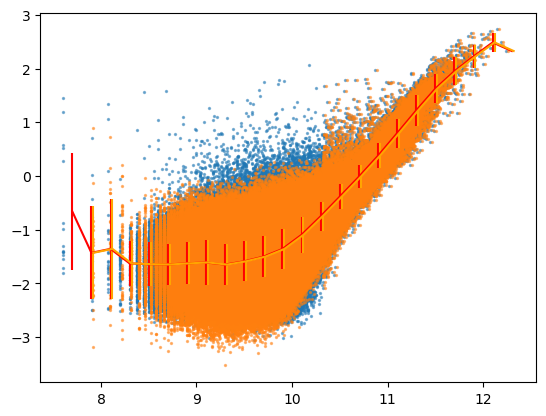

In [4]:
counts, bin_edges = np.histogram(mhalo+10, bins=30, range=(7,13))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

bin_indices = np.digitize(mhalo+10, bin_edges) 
sfr_mean = []
sfr_sigma = []
for i in range(1, len(bin_edges)):
    bin_mask = (bin_indices == i)  
    sfr_bin = sfr[bin_mask] 
    sfr_mean.append(np.mean(sfr_bin[sfr_bin > -100]))   
    sfr_sigma.append(np.std(sfr_bin[sfr_bin > -100]))  

#plt.plot(bin_centers, non_zero_w_ratios, marker='o', linestyle='-')

plt.scatter(mhalo+10, sfr, s=2, alpha=0.5)
plt.errorbar(bin_centers, sfr_mean, sfr_sigma, color="red")

index = 0
f_linear_mean = interp1d(bin_centers[index:], sfr_mean[index:], fill_value="extrapolate")
f_linear_sigma = interp1d(bin_centers[index:], sfr_sigma[index:], bounds_error=False, fill_value=(sfr_sigma[20],sfr_sigma[-1]))

index2 = 16
new_sfr = np.copy(sfr)
condition = (mhalo + 10) <= bin_centers[index2]
new_sfr[condition] = np.random.normal(
    f_linear_mean(mhalo[condition]+10),
    f_linear_sigma(mhalo[condition]+10)
)
plt.scatter(mhalo+10+0.02, new_sfr, s=2, alpha=0.5)
plt.errorbar(bin_centers+0.02, f_linear_mean(bin_centers), f_linear_sigma(bin_centers), color="orange")
print(f_linear_mean(bin_centers))


(array([ 0.,  0.,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan]),
 array([ 7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,  9. ,
         9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. , 11.2,
        11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. ]),
 <a list of 30 Patch objects>)

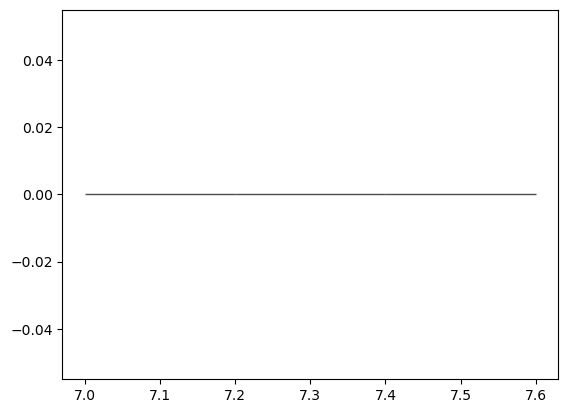

In [53]:
#plt.hist(mhalo+10, bins=30, weights=10**sfr, edgecolor='black', alpha=0.7, range=(7,13))
#plt.yscale("log")
plt.hist(mhalo+10, bins=30, weights=10**sfr, edgecolor='black', alpha=0.7, cumulative=True, range=(7,13))
plt.hist(mhalo+10, bins=30, weights=10**new_sfr, edgecolor='black', alpha=0.7, cumulative=True, range=(7,13))

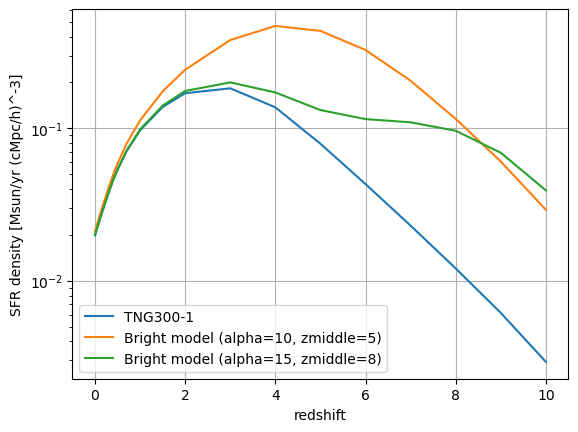

In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt


data = np.loadtxt("SFRD_TNG300-1.txt")
redshift = data[:,1]
sfrd = data[:,2]

plt.figure()

def factor(x, alpha=10, z_middle=5):
    y = (alpha - 1) * (0.5 * (np.tanh(0.5 * (x-z_middle)) + 1) ) + 1
    return y

plt.plot(redshift, sfrd, label="TNG300-1")

a = factor(redshift)
plt.plot(redshift, a*sfrd, label="Bright model (alpha=10, zmiddle=5)")

a = factor(redshift, alpha=15, z_middle=8)
plt.plot(redshift, a*sfrd, label="Bright model (alpha=15, zmiddle=8)")

plt.xlabel("redshift")
plt.ylabel("SFR density [Msun/yr (cMpc/h)^-3]")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

